In [275]:
# importing the necessary packages

import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import geopy as gpy
import folium as fl
import calendar
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

### Data

The data consists of a series of wifi-connected robotic vacuum cleaners available for sale worldwide. These robots are capable of autonomously navigating a home to vacuum
its floors. Upon mission completion, they send a summary report of the mission to cloud services, where it is processed and stored as a row in a database. However,
any cleaning mission performed while the robot is not connected to wifi (either by user's choice or a faulty connection) will not be saved in the database. In addition,
there are occasional periods where cloud services malfunction and no missions are reported, resulting in discrete periods of data loss.<br><br>
These robots are programmed with an automatic recharge and resume function, which means that when the robot detects its battery levels reaching critically low
levels, it will navigate back to the charging dock if available and charge for up to 90 minutes before resuming the mission. In addition, if a robot becomes stuck on an
obstacle in its environment or is manually paused by a button press, it will cease cleaning for up to 90 minutes before terminating the mission. If the user restarts the
mission with a button press within 90 minutes of the pause, the robot will continue cleaning normally. The number of minutes spent cleaning, charging, or paused are
reported for each mission, as is the mission outcome (a field describing whether the mission was cancelled, the robot got stuck, the battery died, or the robot
completed the job successfully).


In [460]:
mission_df = pd.read_csv("mission_data.csv.bz2")
mission_df.head()

robotid             datetime  nmssn  runm  chrgm  pausem outcome
0  000NG2FMLJBT9ANZ  2017-10-01 16:17:22     40     3      1       2   stuck
1  000NG2FMLJBT9ANZ  2017-10-03 14:25:56     41    83      0      13      ok
2  000NG2FMLJBT9ANZ  2017-10-04 12:32:51     42    66     13      12      ok
3  000NG2FMLJBT9ANZ  2017-10-26 02:12:55     45    72     24       0    cncl
4  000NG2FMLJBT9ANZ  2017-10-27 07:17:39     46    61      9       0    cncl

In [461]:
geo_df = pd.read_csv("geo_data.csv.bz2")
geo_df.head()

country_cd          timezone           robotid
0         SE  Europe/Stockholm  T29NF13ZIYISNF79
1         JP        Asia/Tokyo  9S12V26O6G426OYR
2         IL    Asia/Jerusalem  QI6X3P9JKNILKKU1
3         IL    Asia/Jerusalem  7OMKNWMWA4XWC911
4         IL    Asia/Jerusalem  YO63CL0ZFK83SYCZ

### Feature Engineering

In [462]:
# convert the "datetime" into a datetime object so that it is easier to perform further manipulations

mission_df['datetime'] = mission_df.datetime.astype('datetime64')

In [463]:
# Creating a date column

mission_df['date'] = mission_df['datetime'].dt.date

In [464]:
# Creating a year column

mission_df['year'] = mission_df['datetime'].dt.year

In [465]:
# Creating a month column

mission_df['month'] = mission_df['datetime'].dt.month
mission_df['month'] = mission_df['month'].apply(lambda x: calendar.month_abbr[x])

In [466]:
# Ordering the month of the year column

mission_df['month'] = pd.Categorical(mission_df['month'], 
                                 categories= ['Jan','Feb','Mar','Apr','May','Jun', 'Jul',
                                             'Aug','Sep','Oct','Nov','Dec'],
                                              ordered = True)

In [467]:
# Creating a day of the week column

mission_df['day_of_week'] = [d.day_name() for d in mission_df['datetime']]

In [468]:
# Ordering the day of the week column

mission_df['day_of_week'] = pd.Categorical(mission_df['day_of_week'], 
                                 categories= ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
                                              ordered = True)

In [469]:
# Creating the time of the day column

mission_df['time'] = [d.time() for d in mission_df['datetime']]

In [470]:
# Splitting the the time of the day column into different sessions in a day

mission_df=mission_df.assign(session=pd.cut(mission_df.datetime.dt.hour,
                            [0,6,12,18,23],
                            labels=['Night','Morning','Afternoon','Evening'],
                            include_lowest=True))

In [471]:
mission_df.head()

robotid            datetime  nmssn  runm  chrgm  pausem outcome  \
0  000NG2FMLJBT9ANZ 2017-10-01 16:17:22     40     3      1       2   stuck   
1  000NG2FMLJBT9ANZ 2017-10-03 14:25:56     41    83      0      13      ok   
2  000NG2FMLJBT9ANZ 2017-10-04 12:32:51     42    66     13      12      ok   
3  000NG2FMLJBT9ANZ 2017-10-26 02:12:55     45    72     24       0    cncl   
4  000NG2FMLJBT9ANZ 2017-10-27 07:17:39     46    61      9       0    cncl   

         date  year month day_of_week      time    session  
0  2017-10-01  2017   Oct      Sunday  16:17:22  Afternoon  
1  2017-10-03  2017   Oct     Tuesday  14:25:56  Afternoon  
2  2017-10-04  2017   Oct   Wednesday  12:32:51    Morning  
3  2017-10-26  2017   Oct    Thursday  02:12:55      Night  
4  2017-10-27  2017   Oct      Friday  07:17:39    Morning

In [472]:
# splitting the continent and the country from the time zone

temp = geo_df['timezone'].str.split('/', n=1,expand=True)
geo_df['continent'] = temp[0]
geo_df['city'] = temp[1]
geo_df.head()

country_cd          timezone           robotid continent       city
0         SE  Europe/Stockholm  T29NF13ZIYISNF79    Europe  Stockholm
1         JP        Asia/Tokyo  9S12V26O6G426OYR      Asia      Tokyo
2         IL    Asia/Jerusalem  QI6X3P9JKNILKKU1      Asia  Jerusalem
3         IL    Asia/Jerusalem  7OMKNWMWA4XWC911      Asia  Jerusalem
4         IL    Asia/Jerusalem  YO63CL0ZFK83SYCZ      Asia  Jerusalem

In [473]:
# merging the two dataframes

combined_df = geo_df.merge(mission_df,how='left')
combined_df.head()

country_cd          timezone           robotid continent       city  \
0         SE  Europe/Stockholm  T29NF13ZIYISNF79    Europe  Stockholm   
1         SE  Europe/Stockholm  T29NF13ZIYISNF79    Europe  Stockholm   
2         SE  Europe/Stockholm  T29NF13ZIYISNF79    Europe  Stockholm   
3         SE  Europe/Stockholm  T29NF13ZIYISNF79    Europe  Stockholm   
4         SE  Europe/Stockholm  T29NF13ZIYISNF79    Europe  Stockholm   

             datetime  nmssn  runm  chrgm  pausem outcome        date    year  \
0 2017-08-10 19:15:38   16.0  26.0    0.0     5.0      ok  2017-08-10  2017.0   
1 2017-08-10 03:09:12   17.0  63.0    0.0    14.0      ok  2017-08-10  2017.0   
2 2017-08-11 17:05:58   18.0  49.0    0.0    11.0     bat  2017-08-11  2017.0   
3 2017-08-12 02:09:54   19.0  39.0    0.0     8.0      ok  2017-08-12  2017.0   
4 2017-08-12 16:38:55   21.0  38.0    0.0     8.0      ok  2017-08-12  2017.0   

  month day_of_week      time    session  
0   Aug    Thursday  19:15:38    Evening  
1   Aug    Thursday  03:09:12      Night  
2   Aug      Friday  17:05:58  Afternoon  
3   Aug    Saturday  02:09:54      Night  
4   Aug    Saturday  16:38:55  Afternoon

In [474]:
combined_df.isnull().sum()

country_cd      72
timezone         0
robotid          0
continent        0
city             0
datetime       174
nmssn          174
runm           174
chrgm          174
pausem         174
outcome        174
date           174
year           174
month          174
day_of_week    174
time           174
session        174
dtype: int64

In [475]:
# getting the latitude and longitude from a separate file from the internet

country_codes = pd.read_csv("country_codes.csv")
country_codes.head()

country alpha_2code alpha_3code  numeric_code  latitude  longitude
0     Afghanistan          AF         AFG             4   33.0000       65.0
1         Albania          AL         ALB             8   41.0000       20.0
2         Algeria          DZ         DZA            12   28.0000        3.0
3  American Samoa          AS         ASM            16  -14.3333     -170.0
4         Andorra          AD         AND            20   42.5000        1.6

In [476]:
# combining the latitude and longitude data with our dataframe

combined_df = combined_df.merge(country_codes,how="left",left_on="country_cd",right_on="alpha_2code")
combined_df.shape

(376192, 23)

In [477]:
combined_df.head().T

0                    1                    2  \
country_cd                     SE                   SE                   SE   
timezone         Europe/Stockholm     Europe/Stockholm     Europe/Stockholm   
robotid          T29NF13ZIYISNF79     T29NF13ZIYISNF79     T29NF13ZIYISNF79   
continent                  Europe               Europe               Europe   
city                    Stockholm            Stockholm            Stockholm   
datetime      2017-08-10 19:15:38  2017-08-10 03:09:12  2017-08-11 17:05:58   
nmssn                          16                   17                   18   
runm                           26                   63                   49   
chrgm                           0                    0                    0   
pausem                          5                   14                   11   
outcome                        ok                   ok                  bat   
date                   2017-08-10           2017-08-10           2017-08-11   
year                         2017                 2017                 2017   
month                         Aug                  Aug                  Aug   
day_of_week              Thursday             Thursday               Friday   
time                     19:15:38             03:09:12             17:05:58   
session                   Evening                Night            Afternoon   
country                    Sweden               Sweden               Sweden   
alpha_2code                    SE                   SE                   SE   
alpha_3code                   SWE                  SWE                  SWE   
numeric_code                  752                  752                  752   
latitude                       62                   62                   62   
longitude                      15                   15                   15   

                                3                    4  
country_cd                     SE                   SE  
timezone         Europe/Stockholm     Europe/Stockholm  
robotid          T29NF13ZIYISNF79     T29NF13ZIYISNF79  
continent                  Europe               Europe  
city                    Stockholm            Stockholm  
datetime      2017-08-12 02:09:54  2017-08-12 16:38:55  
nmssn                          19                   21  
runm                           39                   38  
chrgm                           0                    0  
pausem                          8                    8  
outcome                        ok                   ok  
date                   2017-08-12           2017-08-12  
year                         2017                 2017  
month                         Aug                  Aug  
day_of_week              Saturday             Saturday  
time                     02:09:54             16:38:55  
session                     Night            Afternoon  
country                    Sweden               Sweden  
alpha_2code                    SE                   SE  
alpha_3code                   SWE                  SWE  
numeric_code                  752                  752  
latitude                       62                   62  
longitude                      15                   15

In [295]:
# columns in the dataframe

combined_df.shape

(376192, 23)

In [293]:
# columns of the dataframe

combined_df.columns

Index(['country_cd', 'timezone', 'robotid', 'continent', 'city', 'datetime',
       'nmssn', 'runm', 'chrgm', 'pausem', 'outcome', 'date', 'year', 'month',
       'day_of_week', 'time', 'session', 'country', 'alpha_2code',
       'alpha_3code', 'numeric_code', 'latitude', 'longitude'],
      dtype='object')

### Task 1. 
### Are there geographic differences in robot usage? - Consider all descriptive features of a mission, including when and how frequently it occurred. - If applicable, comment on how trends in these features might impact design decisions for the hardware, battery, or navigation algorithms of robots sold in different regions.

### Exploratory Data Analysis

outcome  count_of_missions
0     bat               8847
1    cncl             148890
2      ok             195337
3   stuck              22936

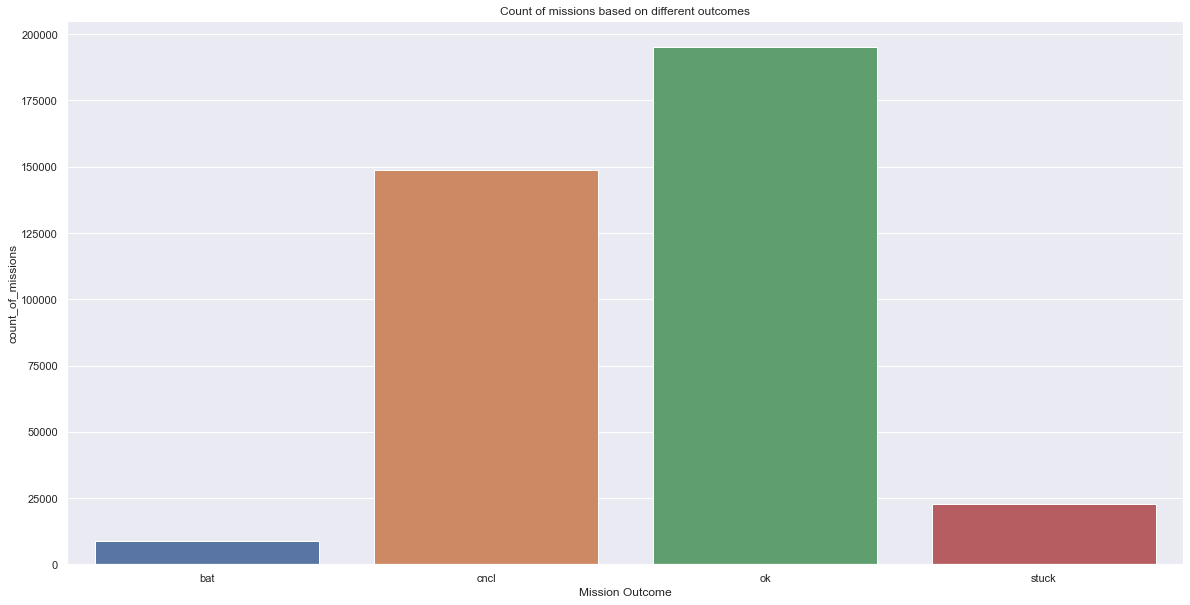

In [375]:
# plotting the count of missions based on different outcomes
sns.set(rc={'figure.figsize':(20,10)})
chart_df = combined_df.groupby(['outcome'],as_index=False).agg(count_of_missions = ('nmssn','count'))
ax = sns.barplot(x='outcome',y='count_of_missions',data=chart_df)
ax.set_title('Count of missions based on different outcomes')
ax.set_xlabel('Mission Outcome')
ax.set_ylabel('count_of_missions');
chart_df

### Insights

We notice that most of the missions performed by the robots (195337 ok missions) were successful in completing the operation which is closely followed by the missions cancelled by the users (148890 cancelled missions). There are comparatively very less number of missions that were struck or bat (where the robot's battery got too low for it to return to the dock. Based on this chart, we shall understand that the overall performance of the robots is very good!

continent  Africa  America    Asia  Atlantic  Australia  Europe  Pacific
outcome                                                                 
bat             4      444    6496         7         76    1806       14
cncl           31     6092  118551       113        891   22997      215
ok             98    13502  129049       316       1931   49992      449
stuck           6     1593   14801        42        202    6244       48

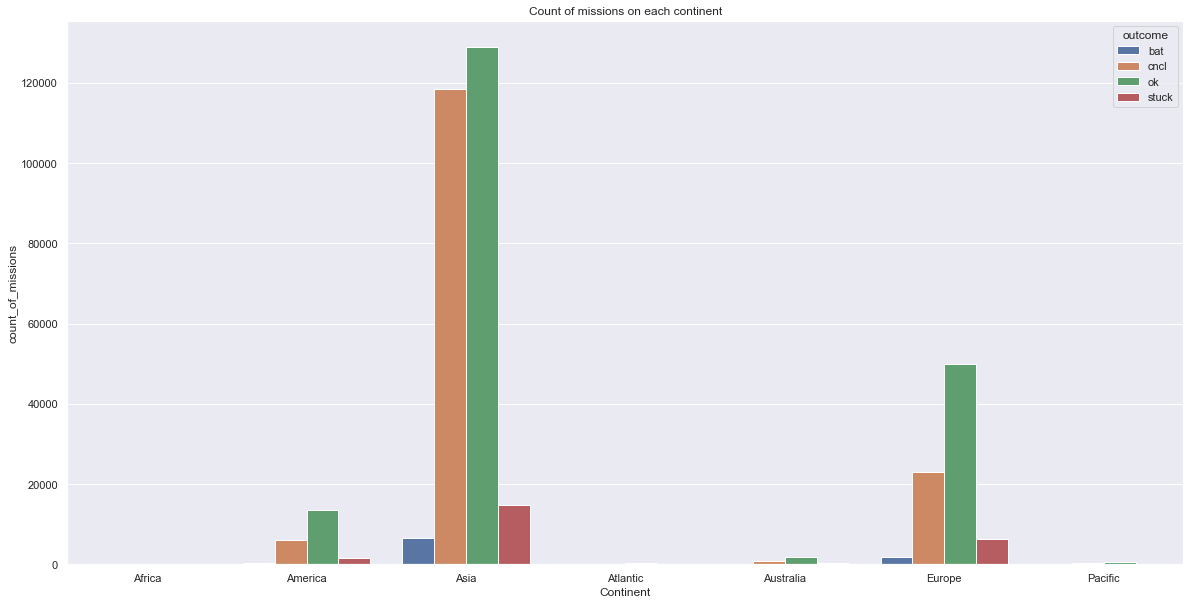

In [478]:
# plotting the count of missions on each continent

chart_df = combined_df.groupby(['continent','outcome'],as_index=False).agg(count_of_missions = ('nmssn','count'))
ax = sns.barplot(x='continent',y='count_of_missions',data=chart_df, hue='outcome')
ax.set_title('Count of missions on each continent')
ax.set_xlabel('Continent')
ax.set_ylabel('count_of_missions');
pd.crosstab(combined_df.outcome,combined_df.continent,
            values=combined_df.robotid, aggfunc='count')

### Insights

Based on the above chart, we notice that most of the missions happened on the Asia and European continents. Interestingly enough, in Asia, the count of successful missions (ok missions) and the count of missions cancelled by the users (cncl missions) are almost close. Whereas in Europe, the count of successful missions (ok missions) and the count of missions cancelled by the users (cncl missions) have a wide gap denoting that there was not much need for a human interference in the mission completion.

Now that there are most number of missions that were performed in the Asia and Europe continents, let us look in how different countries in those two continents different in terms of the robot usage.

### Asia and Europe

In [390]:
# total number of robots in different countries

chart_df = combined_df.groupby(['country_cd'],
        as_index=False).agg(count_of_robots = ('robotid','nunique')).sort_values(by='count_of_robots',ascending= False).head(10)
chart_df

country_cd  count_of_robots
38         IL             6065
17         CN              546
27         FR              487
43         JP              298
4          AT              293
14         CA              282
79         US              238
21         DE              212
7          BE              135
61         PL              122

In [387]:
# total number of robots in different countries in Asia

chart_df = combined_df[combined_df['continent']=='Asia'].groupby(['country_cd'],
        as_index=False).agg(count_of_robots = ('robotid','nunique')).sort_values(by='count_of_robots',ascending= False).head()
chart_df

country_cd  count_of_robots
8          IL             6065
4          CN              546
10         JP              298
26         TW              114
3          BR               34

In [388]:
# total number of robots in different countries in Europe

chart_df = combined_df[combined_df['continent']=='Europe'].groupby(['country_cd'],
        as_index=False).agg(count_of_robots = ('robotid','nunique')).sort_values(by='count_of_robots',ascending= False).head()
chart_df

country_cd  count_of_robots
12         FR              487
1          AT              289
7          DE              212
2          BE              135
25         PL              122

country_cd     AE    AZ   BH     BR       CN    GE     HK    ID        IL  \
outcome                                                                     
bat           5.0   1.0  1.0   30.0    446.0   2.0   11.0   1.0    5476.0   
cncl         63.0  14.0  4.0  350.0   5946.0  21.0  193.0  46.0  104712.0   
ok          136.0  26.0  3.0  822.0  13882.0  57.0  398.0  74.0   97966.0   
stuck         6.0   1.0  NaN  106.0    780.0   7.0   27.0   1.0   11965.0   

country_cd     IN  ...   PH     PR    PS    QA     RU    SA     SG     TH  \
outcome            ...                                                      
bat          15.0  ...  1.0    4.0   3.0   4.0   18.0   3.0   19.0   21.0   
cncl        101.0  ...  6.0   68.0  14.0  19.0  344.0  29.0  292.0  255.0   
ok          274.0  ...  6.0  159.0  24.0  43.0  764.0  66.0  624.0  553.0   
stuck        32.0  ...  NaN   31.0   NaN  13.0   78.0  16.0   84.0   83.0   

country_cd      TW     VN  
outcome                    
bat          140.0    2.0  
cncl        2272.0   70.0  
ok          5216.0  176.0  
stuck        644.0    6.0  

[4 rows x 28 columns]

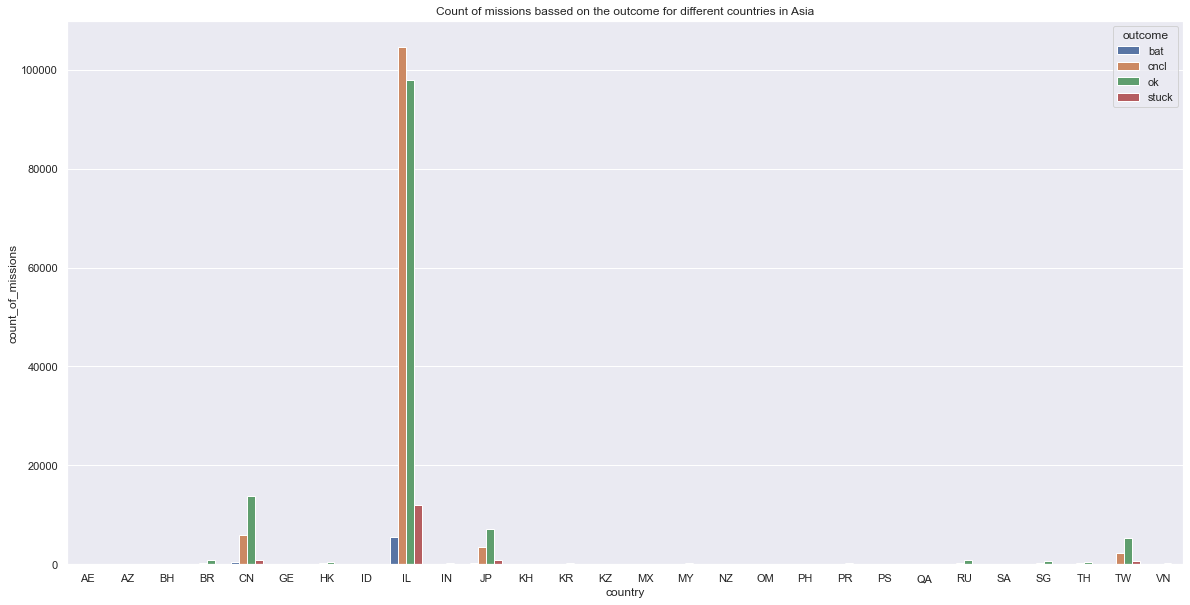

In [377]:
# plotting the count of missions bassed on the outcome for different countries in Asia

chart_df = combined_df[combined_df['continent']=='Asia'].groupby(['country_cd','outcome'],
                                                                   as_index=False).agg(count_of_missions = ('nmssn','count'))
ax = sns.barplot(x='country_cd',y='count_of_missions',data=chart_df, hue='outcome')
ax.set_title('Count of missions bassed on the outcome for different countries in Asia')
ax.set_xlabel('country')
ax.set_ylabel('count_of_missions');
pd.crosstab(combined_df[combined_df['continent']=='Asia'].outcome,combined_df[combined_df['continent']=='Asia'].country_cd,
            values=combined_df.robotid, aggfunc='count')

country_cd    AD      AT      BE    BG    BY      CH      CZ      DE      DK  \
outcome                                                                        
bat          NaN   248.0   116.0   4.0   2.0    40.0    50.0   177.0    48.0   
cncl        14.0  2981.0  1501.0  43.0  37.0   481.0   609.0  2468.0   556.0   
ok          36.0  6401.0  3141.0  91.0  99.0  1118.0  1356.0  5097.0  1217.0   
stuck        NaN   755.0   365.0   3.0  11.0   144.0   171.0   542.0   193.0   

country_cd    EE  ...      NO      PL     PT     RO      RU      SE     SI  \
outcome           ...                                                        
bat          1.0  ...   105.0   111.0   16.0   14.0   152.0    32.0   17.0   
cncl        11.0  ...  1243.0  1246.0  209.0  123.0  1770.0   497.0  206.0   
ok          30.0  ...  2741.0  2678.0  432.0  276.0  4082.0  1059.0  440.0   
stuck        NaN  ...   388.0   353.0   23.0   32.0   658.0   152.0   49.0   

country_cd     SK    TR     UA  
outcome                         
bat          24.0   NaN   17.0  
cncl        473.0  28.0  186.0  
ok          976.0  83.0  395.0  
stuck       148.0  18.0   33.0  

[4 rows x 34 columns]

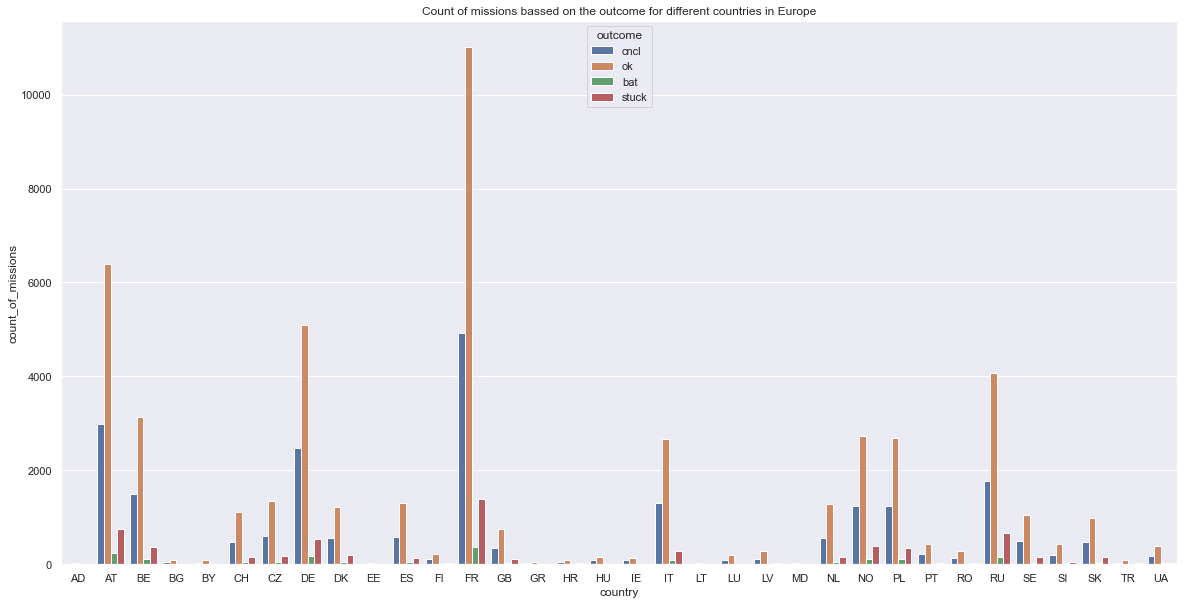

In [378]:
# plotting the count of missions bassed on the outcome for different countries in Europe

chart_df = combined_df[combined_df['continent']=='Europe'].groupby(['country_cd','outcome'],
                                                                   as_index=False).agg(count_of_missions = ('nmssn','count'))
ax = sns.barplot(x='country_cd',y='count_of_missions',data=chart_df, hue='outcome')
ax.set_title('Count of missions bassed on the outcome for different countries in Europe')
ax.set_xlabel('country')
ax.set_ylabel('count_of_missions');
pd.crosstab(combined_df[combined_df['continent']=='Europe'].outcome,combined_df[combined_df['continent']=='Europe'].country_cd,
            values=combined_df.robotid, aggfunc='count')

### Insights

#### Asia:
In Asia, as we can notice from the above charts and tables, most robots have been sold in Israel (6065 robots), and hence Israel also has the most number of missions that happened in a country. It is also useful to note than the number of missions cancelled by the user in Israel is more than the number of successful missions. The second closest is China.

#### Europe:
In Europe, we notice that France has had the most number of robots (487) robots and hence has the most missions as well. The one thing that could be noted is that there are more than 1000 missions that were stuck in France which is high. By investigating further, we could figure out why and how the Roomba robots are being stuck there. The other countries with more missions in Europe are Austria, Germany, Belgium, Russia, etc.

session  Night  Morning  Afternoon  Evening
outcome                                    
bat       2404     1951       2868     1624
cncl     39958    31770      49973    27189
ok       53019    46917      61255    34146
stuck     6207     5377       7372     3980

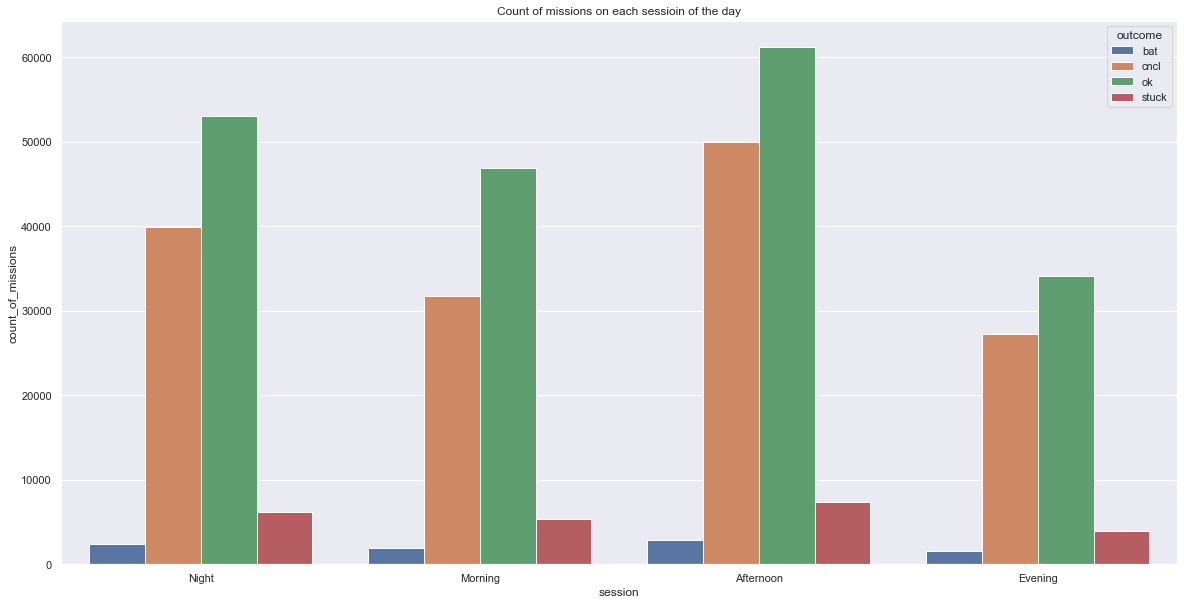

In [433]:
# plotting the performance of robots on different time of the day

chart_df = combined_df.groupby(['session','outcome'],as_index=False).agg(count_of_missions = ('nmssn','count'))
ax = sns.barplot(x='session',y='count_of_missions',data=chart_df, hue='outcome')
ax.set_title('Count of missions on each sessioin of the day')
ax.set_xlabel('session')
ax.set_ylabel('count_of_missions');
pd.crosstab(combined_df.outcome,combined_df.session,values=combined_df.robotid, aggfunc='count')

### Insights

We notice that the Roomba robots are used the most during afternoons and used the least in the evenings.

month     Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct  \
outcome                                                                        
bat       414    473    542    689    694    724    820    834    893    928   
cncl     7600   7915   9962  10613  11562  12394  13481  14499  14440  15320   
ok       9912  10583  12662  13635  15044  16619  17941  18619  18884  20445   
stuck    1076   1099   1447   1592   1659   1915   2066   2315   2228   2471   

month      Nov    Dec  
outcome                
bat        966    870  
cncl     15545  15559  
ok       20420  20573  
stuck     2542   2526

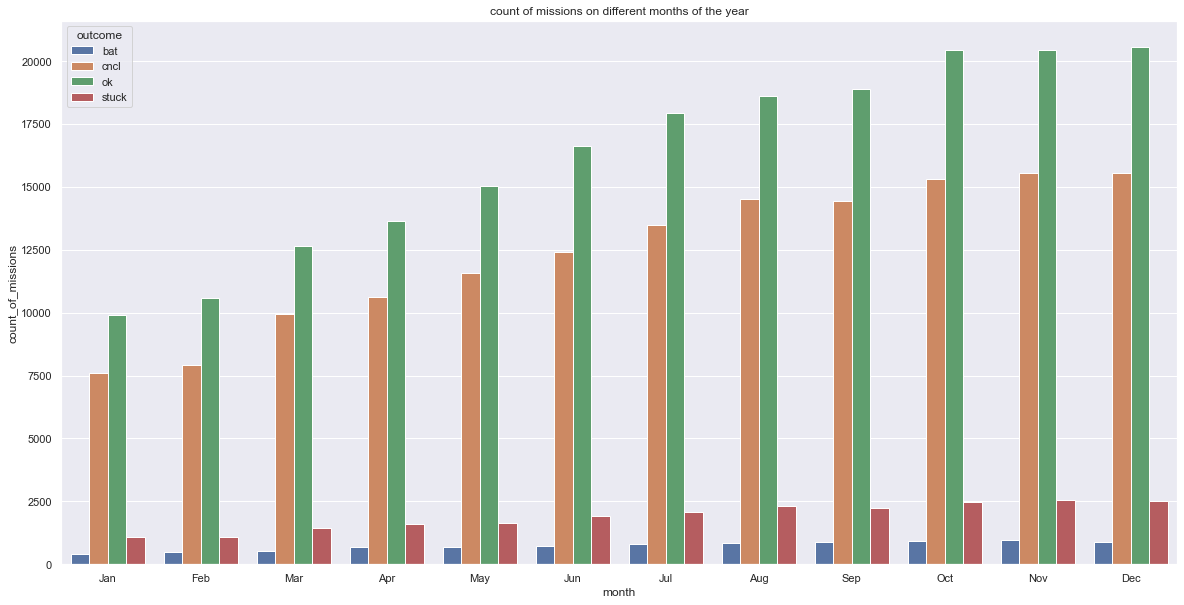

In [479]:
# plotting the performance of robots on different months of the year

chart_df = combined_df.groupby(['month','outcome'],as_index=False).agg(count_of_missions = ('nmssn','count'))
ax = sns.barplot(x='month',y='count_of_missions',data=chart_df, hue='outcome')
ax.set_title('count of missions on different months of the year')
ax.set_xlabel('month')
ax.set_ylabel('count_of_missions');
pd.crosstab(combined_df.outcome,combined_df.month,values=combined_df.robotid, aggfunc='count')

### Insights

We notice that the count of times the Roomba robots are used keeps steadily increasing through the year from January till December before dropping back again in January. 

We could also factor in the weather patterns that cause the Roomba robots to run longer during a certain period of time as compared to the other times. This could be because usually, the initial months of the year (January through April) are colder than the later months of the year (September through December). One of the reasons for this difference in Roomba usage could be that, during cold months, people usually keep all the door and windows closed most of the time resulting in lesser dust being accumulated in the rooms. Therefore, lesser need to use the Roomba robots.

day_of_week  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
outcome                                                                    
bat            1253     1248       1236      1288    1224      1254    1344
cncl          21249    21376      21384     21144   21217     21297   21223
ok            27853    28201      27826     27476   27869     28025   28087
stuck          3263     3258       3367      3243    3333      3192    3280

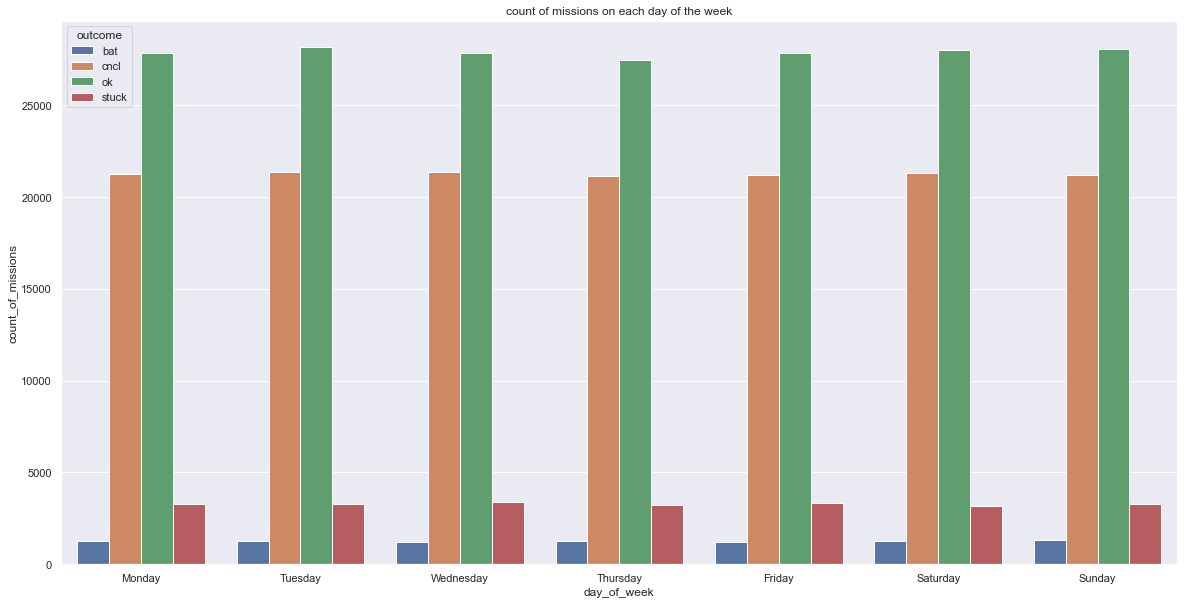

In [329]:
chart_df = combined_df.groupby(['day_of_week','outcome'],as_index=False).agg(count_of_missions = ('nmssn','count'))
ax = sns.barplot(x='day_of_week',y='count_of_missions',data=chart_df, hue='outcome')
ax.set_title('count of missions on each day of the week')
ax.set_xlabel('day_of_week')
ax.set_ylabel('count_of_missions');
pd.crosstab(combined_df.outcome,combined_df.day_of_week,values=combined_df.robotid, aggfunc='count')

### Insights

The count of missions is almost similar on each day of the week denoting that the day of the week is not a significant factor with respect to the performance of the robots!

### Average run time, charge time and pause time of robots across contients

continent     Africa    America       Asia   Atlantic  Australia     Europe  \
outcome                                                                       
bat        61.750000  64.819820  61.647937  57.428571  62.763158  63.460687   
cncl       42.935484  51.415955  52.315198  54.053097  50.810325  50.688351   
ok         50.122449  50.613317  51.617618  49.110759  50.908856  50.787826   
stuck       1.000000   2.943503   2.515371   3.119048   2.797030   3.083921   

continent    Pacific  
outcome               
bat        68.642857  
cncl       51.748837  
ok         49.870824  
stuck       2.437500

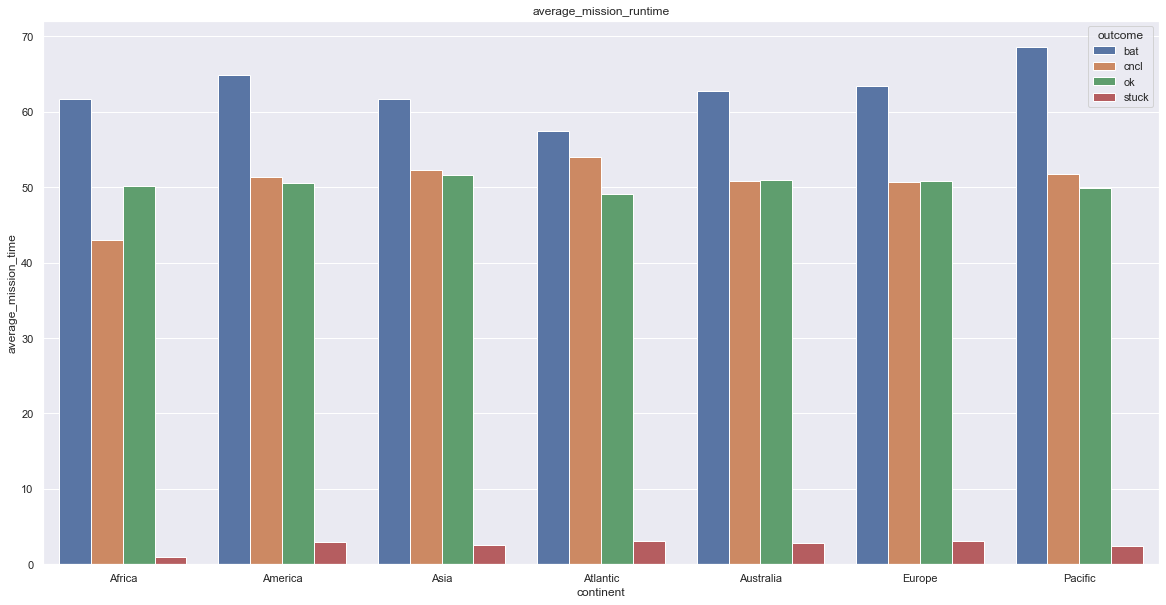

In [312]:
chart_df = combined_df.groupby(['continent','outcome'],as_index=False).agg(average_mission_runtime = ('runm','mean'))
ax = sns.barplot(x='continent',y='average_mission_runtime',data=chart_df, hue='outcome')
ax.set_title('average_mission_runtime')
ax.set_xlabel('continent')
ax.set_ylabel('average_mission_time');
pd.crosstab(combined_df.outcome,combined_df.continent,values=combined_df.runm, aggfunc='mean')

### Insights

We notice that in general average runtime for the missions in which the battery got low is high across all the continents. And the average runtime for "ok" and "cncl" missions are almost the same in all the continents.

continent    Africa   America      Asia  Atlantic  Australia    Europe  \
outcome                                                                  
bat        3.250000  2.011261  7.866533  0.000000   2.776316  2.879845   
cncl       1.709677  2.064511  6.912890  2.752212   2.214366  2.382354   
ok         1.989796  2.116131  6.245039  2.341772   2.017090  2.389482   
stuck      0.000000  0.131199  0.135464  0.142857   0.158416  0.150865   

continent   Pacific  
outcome              
bat        0.928571  
cncl       2.418605  
ok         2.398664  
stuck      0.145833

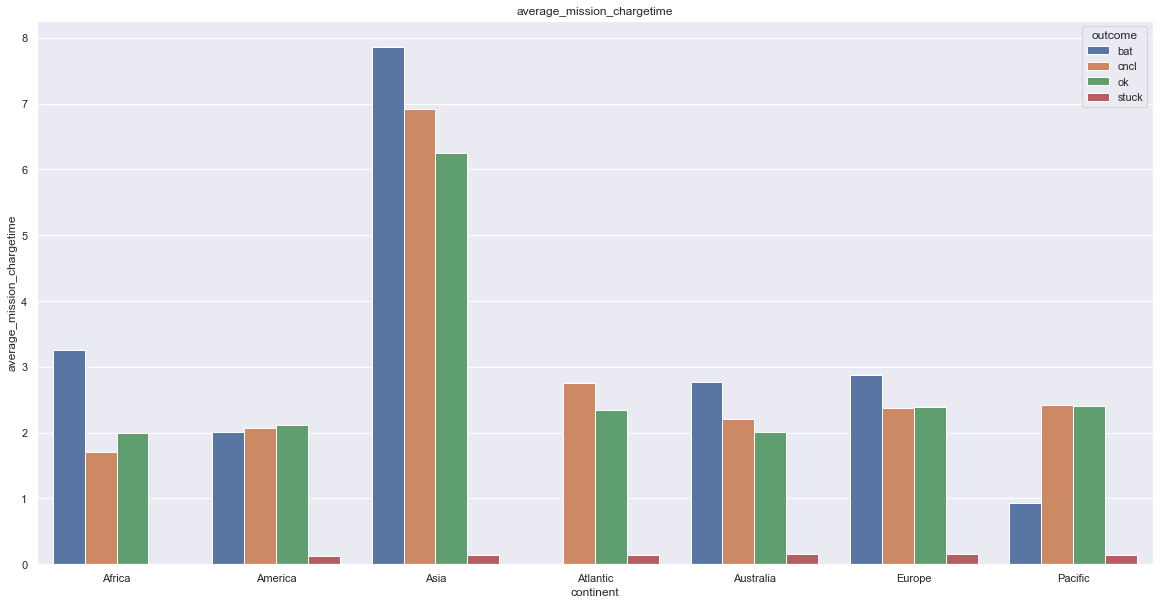

In [313]:

chart_df = combined_df.groupby(['continent','outcome'],as_index=False).agg(average_mission_chargetime = ('chrgm','mean'))
ax = sns.barplot(x='continent',y='average_mission_chargetime',data=chart_df, hue='outcome')
ax.set_title('average_mission_chargetime')
ax.set_xlabel('continent')
ax.set_ylabel('average_mission_chargetime');
pd.crosstab(combined_df.outcome,combined_df.continent,values=combined_df.chrgm, aggfunc='mean')

### Business Recommendation

The average charge time is way too much in Asia as compared to other countries. And also, the missions that got terminated because of batter isssues seem to be higher even with a higher average charge time. So, looking into increasing the battery capacity of the robots sent to Asia could be a possible solution.

continent    Africa   America      Asia  Atlantic  Australia    Europe  \
outcome                                                                  
bat        5.500000  6.603604  8.221675  5.142857   5.644737  6.102436   
cncl       3.838710  5.049573  7.481666  4.973451   5.142536  4.979302   
ok         5.122449  5.044364  6.832095  5.034810   4.764889  5.048368   
stuck      0.000000  0.251099  0.393352  0.261905   0.227723  0.256887   

continent   Pacific  
outcome              
bat        7.071429  
cncl       5.293023  
ok         5.160356  
stuck      0.104167

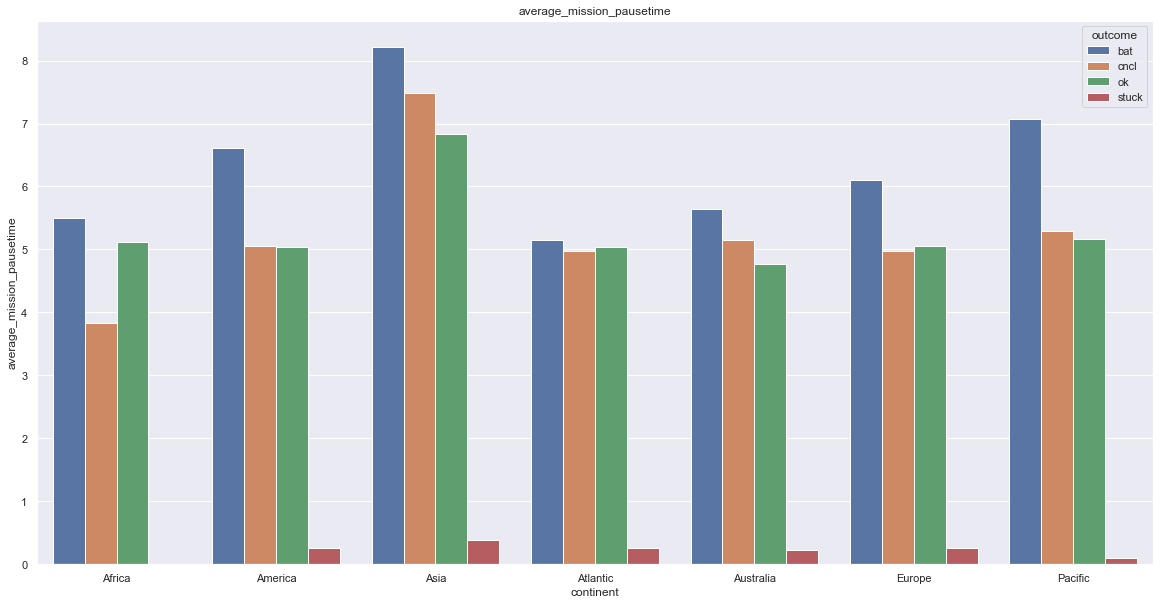

In [314]:

chart_df = combined_df.groupby(['continent','outcome'],as_index=False).agg(average_mission_pausetime = ('pausem','mean'))
ax = sns.barplot(x='continent',y='average_mission_pausetime',data=chart_df, hue='outcome')
ax.set_title('average_mission_pausetime')
ax.set_xlabel('continent')
ax.set_ylabel('average_mission_pausetime');
pd.crosstab(combined_df.outcome,combined_df.continent,values=combined_df.pausem, aggfunc='mean')

### Plotting the geographic data on the world map

### Insights

We notice that the average pause time for the "ok" missions is almost similar across continents except in Asia where is it higher. This could also be because the Roomba robots are used for a longer time in those countries which is a good sign overall.

In [181]:
# getting the Geo data for the world from the internet

world_geo = r'world_countries.json' # geojson file

### Plotting the average runtime of robots across countries

In [230]:
# plotting the average runtime across different countries

country_avg_runtime = combined_df.groupby('alpha_3code',as_index=False).agg(average_run_time = ('runm','mean'))
world_average_runtime = fl.Map(location=[0, 0], zoom_start=2)
world_average_runtime.choropleth(
 geo_data=world_geo,
 data=country_avg_runtime,
 columns=['alpha_3code', 'average_run_time'],
 key_on='id',
 fill_color='YlOrRd', 
 fill_opacity=0.7, 
 line_opacity=0.2,
 legend_name='Average runtime across countries'
)
# display map
world_average_runtime

### Insights

We notice that the average runtime of robots is high in the USA, Canada, Europe, Russia, and southern part of South America regions. This could mean that the robots are used for a longer duration of time in these regions as opposed to countries such as China, India where the average runtime of robots is low.

### Business Recommendation

When the robot is running for a longer period of time, it is natural to experience wear and tear for the Roomba robotic parts. Hence, based on the looking at the average runtime across countries, we could send out personalized offers to customers regarding replacement parts such as brushrolls, filter, side brush, wheels, sensors, etc. This makes sure that the robots are running smoothly.

### Plotting the average charge time of robots across countries

In [231]:
# plotting the average charge time across different countries

country_avg_chargetime = combined_df.groupby('alpha_3code',as_index=False).agg(average_charge_time = ('chrgm','mean'))
world_average_chargetime = fl.Map(location=[0, 0], zoom_start=2)
world_average_chargetime.choropleth(
 geo_data=world_geo,
 data=country_avg_chargetime,
 columns=['alpha_3code', 'average_charge_time'],
 key_on='id',
 fill_color='YlOrRd', 
 fill_opacity=0.7, 
 line_opacity=0.2,
 legend_name='Average charge time across countries'
)
# display map
world_average_chargetime

## Insights

We notice that the average charge time of robots is similar in almost all the countries except for some countries in Europe and some regions in Israel

### Plotting the average pause time of robots across countries

In [232]:
# plotting the average pause time across different countries

country_avg_pausetime = combined_df.groupby('alpha_3code',as_index=False).agg(average_pause_time = ('pausem','mean'))
world_average_pausetime = fl.Map(location=[0, 0], zoom_start=2)
world_average_pausetime.choropleth(
 geo_data=world_geo,
 data=country_avg_pausetime,
 columns=['alpha_3code', 'average_pause_time'],
 key_on='id',
 fill_color='YlOrRd', 
 fill_opacity=0.7, 
 line_opacity=0.2,
 legend_name='Average pause time across countries'
)
# display map
world_average_pausetime

## Insights

We notice that the average pause time of robots is relatively medium in the USA, Canada, Europe, Russia, and  part of South America regions. This could mean that the robots are paused for relatively lesser period of time as compared to countries such as Kazakhstan, Belarus. We may need to investigate further as to whether or not these paused robots were revived to complete the mission within 90 minutes or the mission got terminated due to pause time exceeding 90 minutes.

### Plotting the average run time of "ok" missions across countries

In [435]:
# plotting the average runtime for "ok" missions across different countries

country_avg_runtime_ok = combined_df[combined_df['outcome']=="ok"].groupby('alpha_3code',as_index=False).agg(average_run_time = ('runm','mean'))
world_average_runtime_ok = fl.Map(location=[0, 0], zoom_start=2)
world_average_runtime_ok.choropleth(
 geo_data=world_geo,
 data=country_avg_runtime_ok,
 columns=['alpha_3code', 'average_run_time'],
 key_on='id',
 fill_color='YlOrRd', 
 fill_opacity=0.7, 
 line_opacity=0.2,
 legend_name='Average runtime for "ok" missions across countries'
)
# display map
world_average_runtime_ok

### Insights

We notice that there are many countries where there is high runtime for Roomba robots missions with "ok" outcome. The countries like Finland, Singapore have higher runtimes compared to other countries.

### Plotting the average run time of cancelled missions across countries

In [237]:
# plotting the average runtime for cancelled missions across countries

country_avg_runtime_cncl = combined_df[combined_df['outcome']=="cncl"].groupby('alpha_3code',as_index=False).agg(average_run_time = ('runm','mean'))
world_average_runtime_cncl = fl.Map(location=[0, 0], zoom_start=2)
world_average_runtime_cncl.choropleth(
 geo_data=world_geo,
 data=country_avg_runtime_cncl,
 columns=['alpha_3code', 'average_run_time'],
 key_on='id',
 fill_color='YlOrRd', 
 fill_opacity=0.7, 
 line_opacity=0.2,
 legend_name='Average runtime for cancelled missions across countries'
)
# display map
world_average_runtime_cncl

### Business Recommendation

From the above chart, we notice that the average runtime is more (around 47 minutes) in most of the countries for the missions that are cancelled by the users. This could denote that the there is a huge potential for robots in these countries since they are being used for a longer period of time. But since the missions are being cancelled by the users, following up with those particular segment of customers to figure out the reasons for cancellations could  be very effective in generating design recommendations for future robots. Some of the reasons sound be high noise and frequent need for replacing bins.

### Plotting the average run time of stuck missions across countries

In [238]:
# plotting the average runtime for stuck missions across countries

country_avg_runtime_stuck = combined_df[combined_df['outcome']=="stuck"].groupby('alpha_3code',as_index=False).agg(average_run_time = ('runm','mean'))
world_average_runtime_stuck = fl.Map(location=[0, 0], zoom_start=2)
world_average_runtime_stuck.choropleth(
 geo_data=world_geo,
 data=country_avg_runtime_stuck,
 columns=['alpha_3code', 'average_run_time'],
 key_on='id',
 fill_color='YlOrRd', 
 fill_opacity=0.7, 
 line_opacity=0.2,
 legend_name='Average runtime for stuck missions across countries'
)
# display map
world_average_runtime_stuck

### Design recommendation

There are some counties such as Argentina, Chile, Kazhakstan, Greece, Hungary, Finland that stand out in having a high runtime before they get stuck on an obstacle. These are potential regions where the Roomba robots are running for a longer period of time before being stuck by obstacles. Whereas there are countries such as Nambia, Singapore where the robots get stuck quite quick and do not get recovered. So, by including a sensor in the Roomba robots to figure out what kinds of obstacles make the robot get stuck and not get revived back and comparing the robot navigation data in these two sets of regions could help us navigate the problem <b>(pun intended :P)</b>

In [436]:
# plotting the average runtime for missions for which batter grew too low across countries

country_avg_runtime_bat = combined_df[combined_df['outcome']=="bat"].groupby('alpha_3code',as_index=False).agg(average_run_time = ('runm','mean'))
world_average_runtime_bat = fl.Map(location=[0, 0], zoom_start=2)
world_average_runtime_bat.choropleth(
 geo_data=world_geo,
 data=country_avg_runtime_bat,
 columns=['alpha_3code', 'average_run_time'],
 key_on='id',
 fill_color='YlOrRd', 
 fill_opacity=0.7, 
 line_opacity=0.2,
 legend_name='Average runtime for missions for which batter grew too low across countries'
)
# display map
world_average_runtime_bat

### Design recommendation

Based on the above graph, we can notice that there are many countries such as Singapore, Philippines, Guinea, The Great Britain where the average runtime is much more compared to the other countries. Hence increasing the battery capacity of the Roomba robots sent to these particular countries could be a solution to solving this problem.

### Plotting the total number of robots present across countries

In [239]:
# plotting the Total number of robots in the countries

total_robots_country = combined_df.groupby('alpha_3code',as_index=False).agg(total_robots = ('robotid','nunique'))
world_total_robots = fl.Map(location=[0, 0], zoom_start=2)
world_total_robots.choropleth(
 geo_data=world_geo,
 data=total_robots_country,
 columns=['alpha_3code', 'total_robots'],
 key_on='id',
 fill_color='YlOrRd', 
 fill_opacity=0.7, 
 line_opacity=0.2,
 legend_name='Total number of robots in the country'
)
# display map
world_total_robots

### Insights

The number of robots sold in different countries seems to be relatively the same in most countries.

### Successful vs unsuccessful missions across countries
<b>Assumption:</b> The assumption is that the missions with the outcome "ok" are successful and the missions with either of "stuck","bat","cncl" outcomes are unsuccesful<br>
Pecentage of succesful missions per country = total number of missions with "ok" outcome in that country/total number of missions in that country<br>
Pecentage of unsuccesful missions per country = total number of missions with "stuck","bat","cncl" outcome in that country/total number of missions in that country<br>

In [426]:
# total missions per country for each outcome
total_missions_per_country_per_outcome = combined_df.groupby(['alpha_3code','outcome'],as_index=False).agg(total_missions_per_country_per_outcome = ('nmssn','count'))
# total missions per country
total_missions_per_country = combined_df.groupby(['alpha_3code'],as_index=False).agg(total_missions_per_country = ('nmssn','count'))
missions_pc_po = total_missions_per_country_per_outcome.merge(total_missions_per_country,
                                                                                      how="left",on="alpha_3code")
missions_pc_po = missions_pc_po[missions_pc_po['outcome']=="ok"]
missions_pc_po['succesful_missions_pct'] = round(missions_pc_po['total_missions_per_country_per_outcome']/missions_pc_po['total_missions_per_country']*100,2)
missions_pc_po['unsuccesful_missions_pct'] = 100 - missions_pc_po['succesful_missions_pct']
missions_pc_po.head()

alpha_3code outcome  total_missions_per_country_per_outcome  \
1          AND      ok                                      36   
4          ARE      ok                                     136   
8          ARG      ok                                     318   
12         ATG      ok                                       3   
16         AUS      ok                                    1931   

    total_missions_per_country  succesful_missions_pct  \
1                           50                   72.00   
4                          210                   64.76   
8                          523                   60.80   
12                           8                   37.50   
16                        3100                   62.29   

    unsuccesful_missions_pct  
1                      28.00  
4                      35.24  
8                      39.20  
12                     62.50  
16                     37.71

In [356]:
# plotting the percentage of successful missions in the country

world_successful_robots = fl.Map(location=[0, 0], zoom_start=2)
world_successful_robots.choropleth(
 geo_data=world_geo,
 data=missions_pc_po,
 columns=['alpha_3code', 'succesful_missions_pct'],
 key_on='id',
 fill_color='YlOrRd', 
 fill_opacity=0.7, 
 line_opacity=0.2,
 legend_name='Percentage of successful missions in the country'
)
# display map
world_successful_robots

In [357]:
# plotting the percentage of unsuccessful missions in the country

world_unsuccessful_robots = fl.Map(location=[0, 0], zoom_start=2)
world_unsuccessful_robots.choropleth(
 geo_data=world_geo,
 data=missions_pc_po,
 columns=['alpha_3code', 'unsuccesful_missions_pct'],
 key_on='id',
 fill_color='YlOrRd', 
 fill_opacity=0.7, 
 line_opacity=0.2,
 legend_name='Percentage of unsuccessful missions in the country'
)
# display map
world_unsuccessful_robots

### Top 10 countries in which the mission outcome of the robots were OK, bat, struck, and cancelled manually

            count_of_robots
country_cd                 
IL                    97966
CN                    13882
FR                    11023
JP                     7185
CA                     6903
AT                     6512
US                     5182
DE                     5097
BE                     3141
NO                     2741


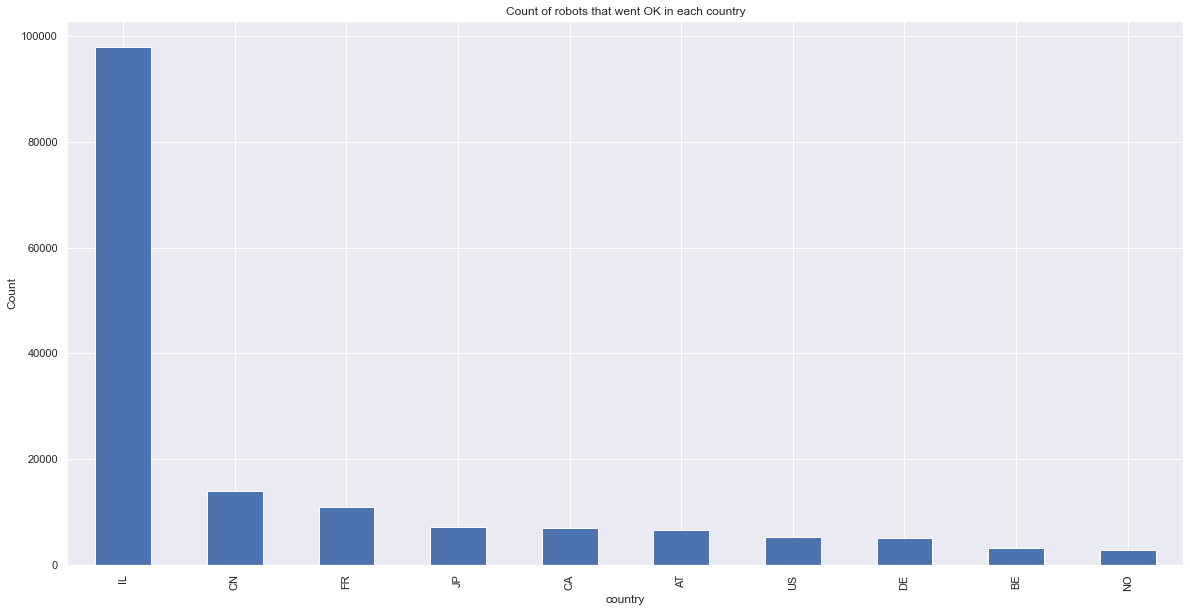

In [124]:
# plotting the top 10 countries in which robots went OK the most

print(combined_df[combined_df['outcome'] == 'ok'].groupby(['country_cd']).agg(count_of_robots = ('robotid','count'))
      .sort_values(ascending=False,by='count_of_robots').head(10))
chart_df = combined_df[combined_df['outcome'] == 'ok'].groupby(['country_cd']).agg(count_of_robots = ('robotid','count'))
      .sort_values(ascending=False,by='count_of_robots').head(10)
ax = combined_df[combined_df['outcome'] == 'ok'].groupby(['country_cd']).count()['robotid'].sort_values(ascending=False).head(10).plot(kind = 'bar', 
                            figsize = (20,10), 
                            title = 'Count of robots that went OK in each country')
ax.set_xlabel('country')
ax.set_ylabel('Count');

            count_of_robots
country_cd                 
IL                     5476
CN                      446
FR                      372
JP                      264
AT                      251
CA                      233
DE                      177
RU                      170
US                      169
TW                      140


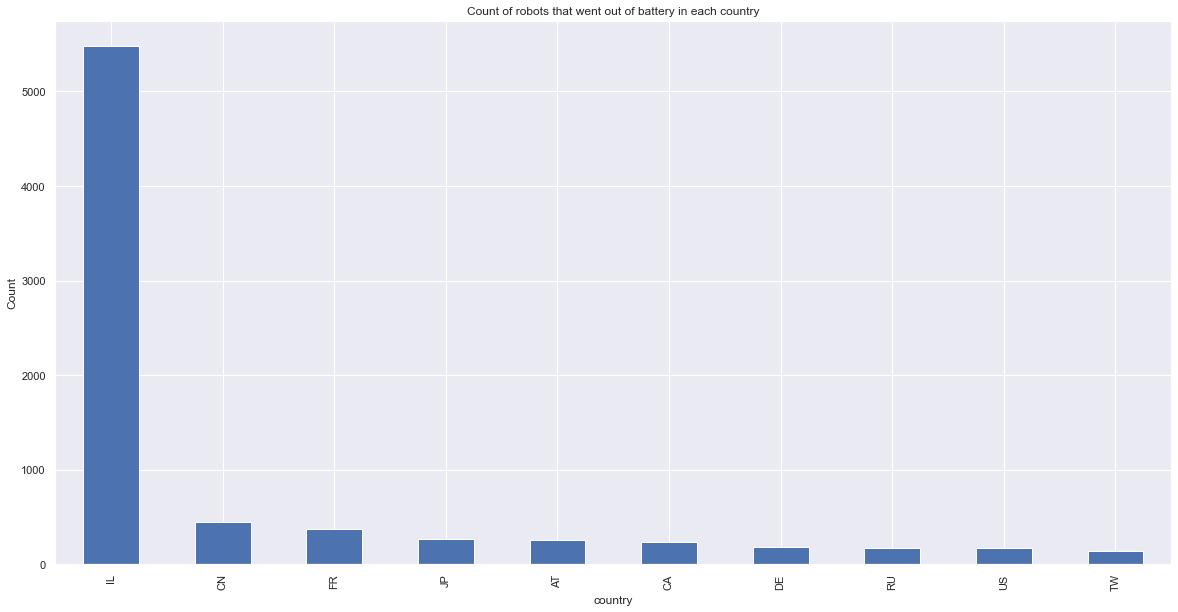

In [145]:
# plotting the top 10 countries in which robots went out of battery the most

print(combined_df[combined_df['outcome'] == 'bat'].groupby(['country_cd']).agg(count_of_robots = ('robotid','count'))
      .sort_values(ascending=False,by='count_of_robots').head(10))
ax = combined_df[combined_df['outcome'] == 'bat'].groupby(['country_cd']).count()['country'].sort_values(ascending=False).head(10).plot(kind = 'bar', 
                            figsize = (20,10), 
                            title = 'Count of robots that went out of battery in each country')
ax.set_xlabel('country')
ax.set_ylabel('Count');

            count_of_robots
country_cd                 
IL                    11965
FR                     1398
JP                      860
CA                      856
CN                      780
AT                      775
RU                      736
TW                      644
US                      560
DE                      542


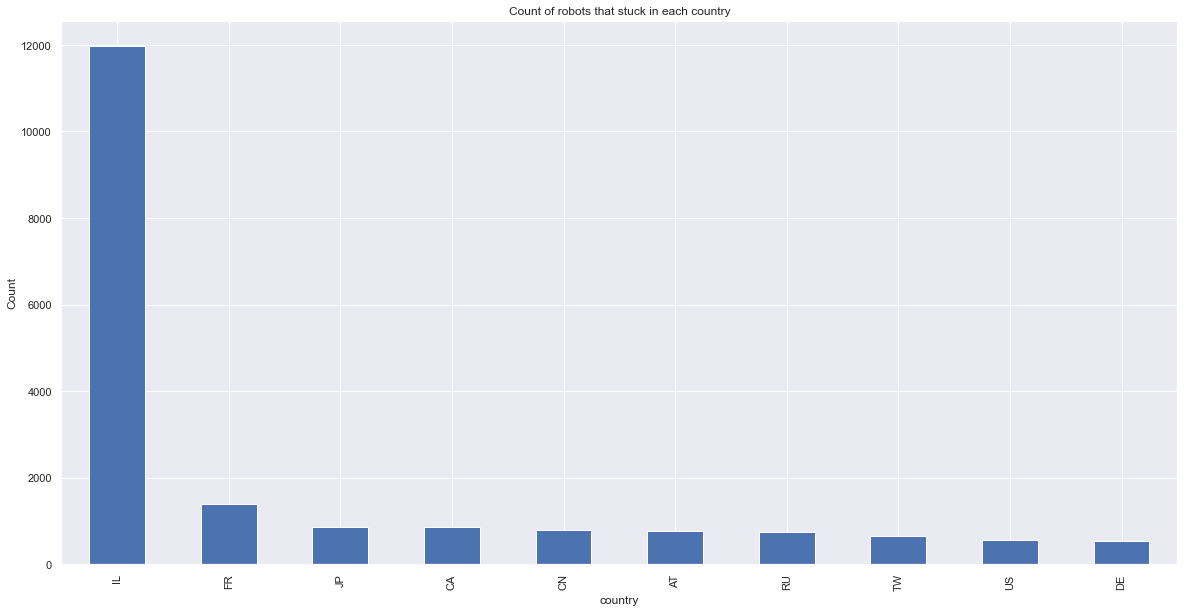

In [437]:
# plotting the top 10 countriesin which robots stuck the most

print(combined_df[combined_df['outcome'] == 'stuck'].groupby(['country_cd']).agg(count_of_robots = ('robotid','count'))
      .sort_values(ascending=False,by='count_of_robots').head(10))
ax = combined_df[combined_df['outcome'] == 'stuck'].groupby(['country_cd']).count()['robotid'].sort_values(ascending=False).head(10).plot(kind = 'bar', 
                            figsize = (20,10), 
                            title = 'Count of robots that stuck in each country')
ax.set_xlabel('country')
ax.set_ylabel('Count');

            count_of_robots
country_cd                 
IL                   104712
CN                     5946
FR                     4926
JP                     3434
CA                     3134
AT                     3020
DE                     2468
US                     2310
TW                     2272
RU                     2114


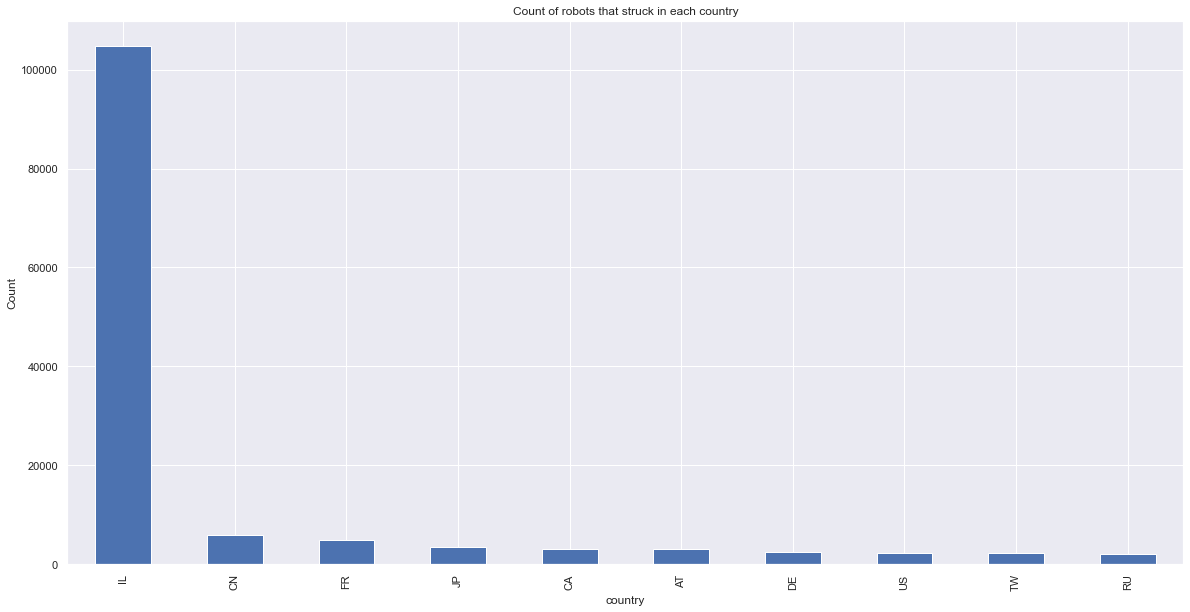

In [147]:
# plotting the top 10 countries in which robots got cancelled the most

print(combined_df[combined_df['outcome'] == 'cncl'].groupby(['country_cd']).agg(count_of_robots = ('robotid','count'))
      .sort_values(ascending=False,by='count_of_robots').head(10))
ax = combined_df[combined_df['outcome'] == 'cncl'].groupby(['country_cd']).count()['robotid'].sort_values(ascending=False).head(10).plot(kind = 'bar', 
                            figsize = (20,10), 
                            title = 'Count of robots that struck in each country')
ax.set_xlabel('country')
ax.set_ylabel('Count');

### Insight

The one country that we see topping in all the 4 charts above is Israal. But this could be due to the fact that Israel has had the most number of robots (6065 robots as we calculated earlier).

continent
Asia         136
Europe        38
America        7
Australia      1
Name: country_cd, dtype: int64


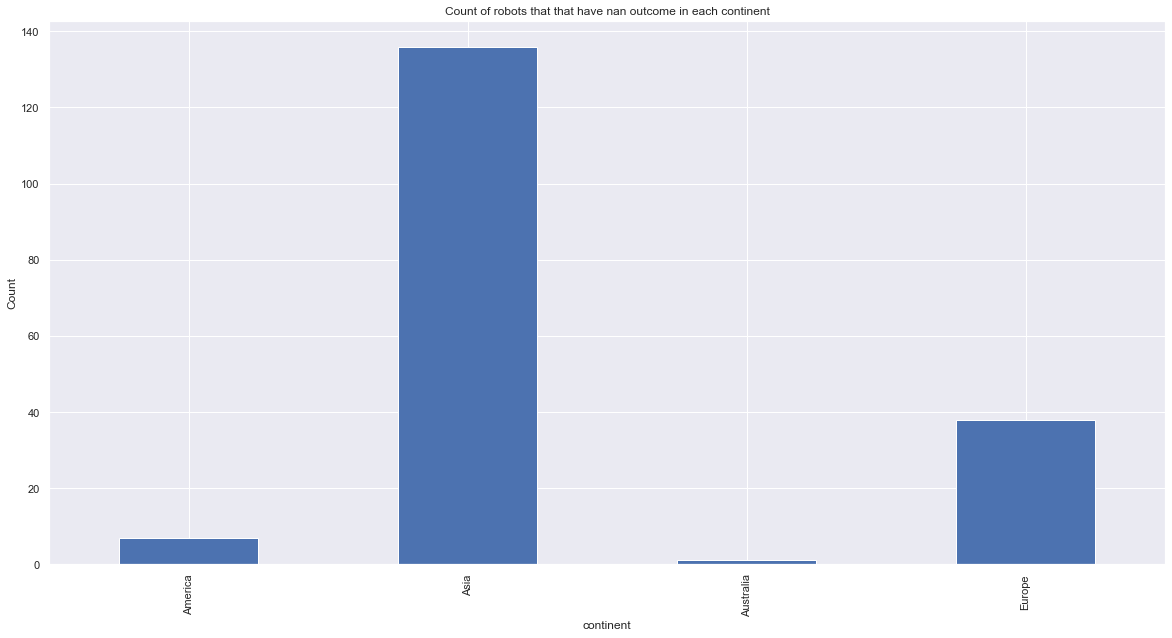

In [148]:
# plotting the count of robots that have unknown outcome in each continent

print(combined_df[combined_df.outcome.isnull()].groupby(['continent']).count()['country_cd']
      .sort_values(ascending=False).head(10))
ax = combined_df[combined_df.outcome.isnull()].groupby(['continent']).count()['country_cd'].plot(kind = 'bar', 
                            figsize = (20,10), 
                            title = 'Count of robots that that have nan outcome in each continent')
ax.set_xlabel('continent')
ax.set_ylabel('Count');

### Insights

The above charge shows that "nan" outcomes where the mission outcome is not known. This could be a part of data loss during transmission to the cloud. There are most nan outcomes in Asia. However, it is minimal in number (just 136 out of over 367679 records). Nevertheless, this is still a reason for concern and needs to be investigated further.

### The daily mission counts for different outcomes

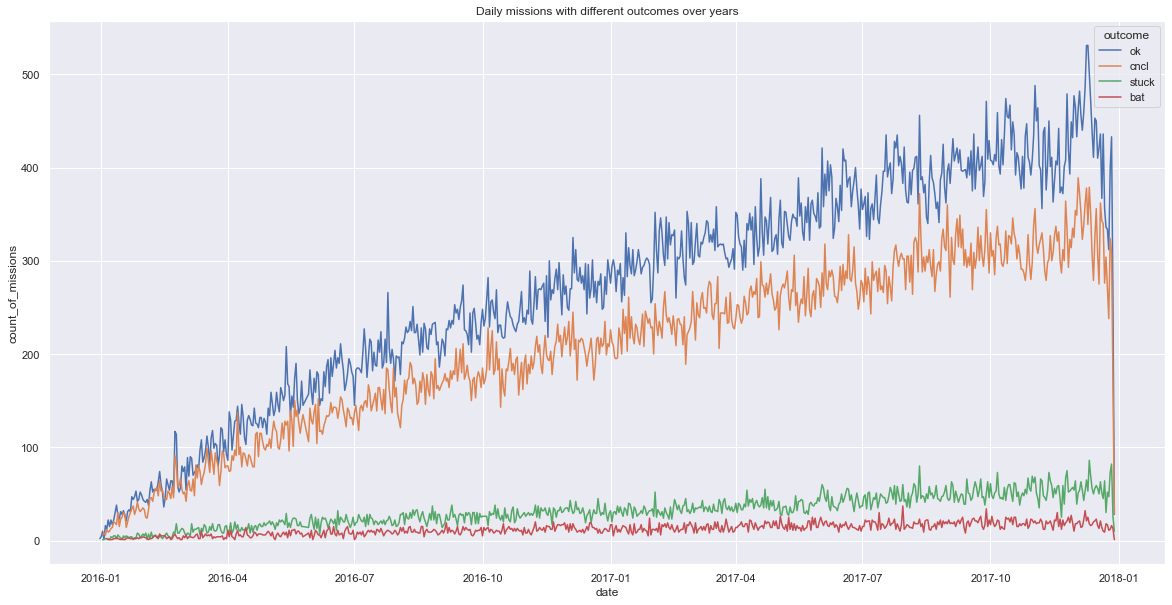

In [459]:
chart_df = combined_df.groupby(['date','outcome'],as_index=False).agg(count_of_missions = ('nmssn','count'))
ax = sns.lineplot(x='date',y='count_of_missions',data=chart_df, hue='outcome')
ax.set_title('Daily missions with different outcomes over years')
ax.set_xlabel('date')
ax.set_ylabel('count_of_missions');

### Insights

The above graph shows that the number of missions with "ok" and "cncl" outcomes has been increasing over time. But this could also be because the number of robots being sold keeps growing over the years. Nevertheless, this is a good sign for the company in terms of keeping up with the consistency in the efficiency of the robots. And the number of missions with "stuck" and "bat" outcomes have been almost constant or increasing very little over time which is also a good thing!

### Task 2.
### We are aware that data loss exists among the mission records, but are unsure of the cause. Quantify the extent of the loss, differentiating between discrete catastrophic events and random mission loss for individual robots.

### Percentage of data loss for each country

### Data loss definition:

We know that upon mission completion, the robots send a summary report of the mission to cloud services, where it is processed and stored as a row in a database. However, any cleaning mission performed while the robot is not connected to wifi (either by user's choice or a faulty connection) will not be saved in the database. In addition, there are occasional periods where cloud services malfunction and no missions are reported, resulting in discrete periods of data loss.

It is also given that the max mission number per robot should reflect its total number of missions to date reported to the database. 

<b> Assumption:</b>
So, we may perceive any missing mission numbers of the "nmssn" column as the missions that were not reported to the cloud services, thereby resulting in data loss.

Based on this assumption, by taking the percentage of missing missions to the total missions in a country, we would be able to find the percentage of data loss for a particular country.

In [359]:
# find the total missions by each of the robots

robot_missions = combined_df.groupby(['robotid'],as_index=False).agg(total_missions = ('nmssn','max'))
robot_missions.total_missions = robot_missions.total_missions.fillna(0)
robot_missions.total_missions = robot_missions.total_missions.astype('int64')
robot_missions

robotid  total_missions
0     000NG2FMLJBT9ANZ              46
1     000Y9NBMJ77LQ7S7              61
2     006Q50H53GXM7BYO              64
3     00EZQ4MZ6JLQPJK6             129
4     00KI1HU70Y15Z10K             108
...                ...             ...
9995  ZZ15EKWDBZBUNLOE             142
9996  ZZ6UI6ZTJ09NSKY5              81
9997  ZZNOFTIZUGAHMRXX              24
9998  ZZNZ8XWEB39GL4XR              96
9999  ZZUJVI3GXRLIG0MT              82

[10000 rows x 2 columns]

In [360]:
# append the total_missions to the dataframe

combined_df = combined_df.merge(robot_missions,how='inner')
combined_df

country_cd          timezone           robotid continent       city  \
0              SE  Europe/Stockholm  T29NF13ZIYISNF79    Europe  Stockholm   
1              SE  Europe/Stockholm  T29NF13ZIYISNF79    Europe  Stockholm   
2              SE  Europe/Stockholm  T29NF13ZIYISNF79    Europe  Stockholm   
3              SE  Europe/Stockholm  T29NF13ZIYISNF79    Europe  Stockholm   
4              SE  Europe/Stockholm  T29NF13ZIYISNF79    Europe  Stockholm   
...           ...               ...               ...       ...        ...   
376187         IL    Asia/Jerusalem  D3M0HI19ZYY167PF      Asia  Jerusalem   
376188         IL    Asia/Jerusalem  D3M0HI19ZYY167PF      Asia  Jerusalem   
376189         IL    Asia/Jerusalem  D3M0HI19ZYY167PF      Asia  Jerusalem   
376190         IL    Asia/Jerusalem  D3M0HI19ZYY167PF      Asia  Jerusalem   
376191         IL    Asia/Jerusalem  D3M0HI19ZYY167PF      Asia  Jerusalem   

                  datetime  nmssn   runm  chrgm  pausem  ... day_of_week  \
0      2017-08-10 19:15:38   16.0   26.0    0.0     5.0  ...    Thursday   
1      2017-08-10 03:09:12   17.0   63.0    0.0    14.0  ...    Thursday   
2      2017-08-11 17:05:58   18.0   49.0    0.0    11.0  ...      Friday   
3      2017-08-12 02:09:54   19.0   39.0    0.0     8.0  ...    Saturday   
4      2017-08-12 16:38:55   21.0   38.0    0.0     8.0  ...    Saturday   
...                    ...    ...    ...    ...     ...  ...         ...   
376187 2017-11-24 06:55:24   76.0    7.0    0.0     0.0  ...      Friday   
376188 2017-11-25 04:15:25   77.0   17.0    0.0     8.0  ...    Saturday   
376189 2017-11-24 05:16:11   78.0   11.0    5.0     8.0  ...      Friday   
376190 2017-11-24 11:55:00   80.0  131.0    0.0     0.0  ...      Friday   
376191 2017-11-24 05:07:23   82.0   42.0    0.0     9.0  ...      Friday   

            time    session country alpha_2code alpha_3code numeric_code  \
0       19:15:38    Evening  Sweden          SE         SWE        752.0   
1       03:09:12      Night  Sweden          SE         SWE        752.0   
2       17:05:58  Afternoon  Sweden          SE         SWE        752.0   
3       02:09:54      Night  Sweden          SE         SWE        752.0   
4       16:38:55  Afternoon  Sweden          SE         SWE        752.0   
...          ...        ...     ...         ...         ...          ...   
376187  06:55:24      Night  Israel          IL         ISR        376.0   
376188  04:15:25      Night  Israel          IL         ISR        376.0   
376189  05:16:11      Night  Israel          IL         ISR        376.0   
376190  11:55:00    Morning  Israel          IL         ISR        376.0   
376191  05:07:23      Night  Israel          IL         ISR        376.0   

       latitude longitude total_missions  
0          62.0     15.00             96  
1          62.0     15.00             96  
2          62.0     15.00             96  
3          62.0     15.00             96  
4          62.0     15.00             96  
...         ...       ...            ...  
376187     31.5     34.75             82  
376188     31.5     34.75             82  
376189     31.5     34.75             82  
376190     31.5     34.75             82  
376191     31.5     34.75             82  

[376192 rows x 24 columns]

In [361]:
# calculating the total reported missions

total_reported_missions = combined_df.groupby('robotid',as_index=False).agg(total_reported_missions = ('country_cd','count'))
total_reported_missions

robotid  total_reported_missions
0     000NG2FMLJBT9ANZ                        5
1     000Y9NBMJ77LQ7S7                        7
2     006Q50H53GXM7BYO                       36
3     00EZQ4MZ6JLQPJK6                       48
4     00KI1HU70Y15Z10K                       28
...                ...                      ...
9995  ZZ15EKWDBZBUNLOE                       70
9996  ZZ6UI6ZTJ09NSKY5                       13
9997  ZZNOFTIZUGAHMRXX                        5
9998  ZZNZ8XWEB39GL4XR                       18
9999  ZZUJVI3GXRLIG0MT                       29

[10000 rows x 2 columns]

In [362]:
# merging the total_reported_missions in the dataframe

combined_df = combined_df.merge(total_reported_missions,how="left",on="robotid")
combined_df.shape

(376192, 25)

In [363]:
# calculating the percentage of missions that were not reported

combined_df['data_loss'] = round((combined_df['total_missions']-combined_df['total_reported_missions'])
                                 /combined_df['total_missions']*100,2)
combined_df.shape

(376192, 26)

In [364]:
temp_df = combined_df.loc[:,['alpha_3code','total_reported_missions', 'total_missions']].drop_duplicates().reset_index()
temp_df.drop(columns=['index'],inplace=True)
temp_df = temp_df.groupby('alpha_3code',as_index=False).agg(total_reported_missions = ('total_reported_missions','sum'),
                               total_missions = ('total_missions','sum'))
temp_df['data_loss_percentage'] = round((temp_df['total_missions'] - temp_df['total_reported_missions'])/temp_df['total_missions']*100,2)
temp_df

alpha_3code  total_reported_missions  total_missions  data_loss_percentage
0          AND                       50              82                 39.02
1          ARE                      210             450                 53.33
2          ARG                      523            1254                 58.29
3          ATG                        8              72                 88.89
4          AUS                     3087            6727                 54.11
..         ...                      ...             ...                   ...
79         URY                      182             386                 52.85
80         USA                     8118           18628                 56.42
81         VEN                        2              74                 97.30
82         VNM                      254             229                -10.92
83         ZAF                       76             165                 53.94

[84 rows x 4 columns]

We notice that Vietnam has a data loss percentage that is less than 0. This could be an anomaly or some data point could have been misrecorded. We may need to know more about how the data is being collected to further investigate why were there more reported missions than the total number of missions in Vietnam. But for now, we shall disregard this data point.

In [365]:
temp_df = temp_df[temp_df['data_loss_percentage']>0]

In [218]:
world_map = fl.Map(location=[0, 0], zoom_start=2)
world_map.choropleth(
 geo_data=world_geo,
 data=temp_df,
 columns=['alpha_3code', 'data_loss_percentage'],
 key_on='id',
 fill_color='YlOrRd', 
 fill_opacity=0.7, 
 line_opacity=0.2,
 legend_name='Percentage of data loss across countries'
)
# display map
world_map

### Insights

We notice that the percentage of data loss is pretty similar across the countries, around 40-50%. This is a cause for concern because almost half of the missions that are performed by the robot are not being recorded.
Venezuela and Nambia are countries where there is a relatively significant data loss.
Russia fares better in this regard and has the minimum data loss.

### Design recommendations to reduce data loss:

- Wifi transmission: One of the major reasons for the data loss could be WiFi connectivity. By improving the sensors that transmit data to the cloud, this issue could be overcome better.
- Data collection sensor: It could be possible that the sensors responsible for collecting the mission data become faulty due to overuse. So, looking into the difference in the time period from which the Roomba robot was first used and when the data loss started occurring, we may zero in on the cause.
- Maintenance of crucial parts: The data loss could also happen when some critical parts of the Roomba robot malfunction. So, enabling a software program to notify the user of weary parts responsible for data transmission could help to prevent data loss.

### Catastrophic loss ideation

Based on the above map, we can find the countries with the highest percentage of Roomba Robot missions that were not recorded in the database. One way that I perceive a catastrophic data loss is when a big chunk of missions is missing in tandem. For each country, we could find the ratio of consecutive missing mission numbers to the total missions performed by individual robots to know the percentage of consecutive missing missions in a particular country. Based on a threshold percentage of consecutive missing missions that the business stakeholders decide, we may classify a country as a potential candidate to further investigate the catastrophic loss to analyze whether this loss is uniform or random.<br><br><br><br>

I enjoyed working on the data challenge!

Thank you very much for the opportunity!


### Kishor Kumar Sridhar
### kishorkumarsridhar@gmail.com